In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

rng = np.random.default_rng()

In [2]:
def concat_map(x):
    n,a,b = x.shape
    nt = np.arange(n)[:,None,None]
    nt = np.repeat(nt, a, 1)
    nt = np.repeat(nt, b, 2)+1
    return (nt * x).sum(0)

def divide_map(x, n_t=None):
    if not n_t:
        n_t = x.max()
    return np.stack([x==i+1 for i in range(int(n_t))]).astype(float)
    
def collapse(x):
    assert x.ndim == 2
    ay,ax = x.shape
    idxs = x.nonzero()
    an = len(idxs[0])
    t = np.zeros((an,ay,ax))
    t[range(an),idxs[0],idxs[1]] = 1
    return t

def show(x, vmax):
    plt.imshow(x, cmap='tab20', vmax=vmax)
    plt.colorbar()
    
def maps2im(maps, types):
    return ((maps.T * types).T).sum(0)

def show_maps(maps, types):
    show(maps2im(maps, types), vmax=n_types-1)
    
def Show_maps():
    show_maps(maps, types)
    
def Show_all_maps_at(i):
    show_maps(all_maps[i], all_types[i])
    
def maps2tyx(maps):
    t = np.zeros((n_types,Y,X))
    z,y,x = maps.nonzero()
    t[types,y,x] = 1.
    return t

In [3]:
kernel_zero = np.array(
       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]
)

kernel_plus = np.array(
       [[0., 1., 0.],
        [1., 1., 1.],
        [0., 1., 0.]]
)

kernel_right = np.array(
       [[0., 0., 0.],
        [0., 0., 1.],
        [0., 0., 0.]]
)

kernel_left = np.array(
       [[0., 0., 0.],
        [1., 0., 0.],
        [0., 0., 0.]]
)

kernel_center = np.array(
       [[0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]]
)

kernel_plus_mask = kernel_plus > 0

kernel_evo = kernel_plus.copy()
kernel_evo[1,1] = -4
kernel_evo

k_mask = kernel_plus.copy()
k_blue = kernel_plus.copy()
k_blue[1,1]=0
k_blue*=2
k_yellow = k_blue.copy()*-1
k_stay = kernel_center.copy()
k_go = kernel_plus.copy()
k_go[1,1]=0

In [4]:
import itertools

confs = np.array(list(itertools.permutations([0,1,2,3,4,5], 5)))/5

def gen_kernels(n_types, use_k=True, rng_=None):
    if rng_ is not None:
        rng = rng_
    kernels = [[None]*n_types]
    for i in range(n_types-1):
        cs = rng.choice(confs, n_types)
        coefs = rng.uniform(-2,2, (n_types,5))
        kernels_i = []
        for c,k in zip(cs,coefs):
            x = kernel_plus.copy()
            x[kernel_plus_mask] = c*(k if use_k else 1)
            kernels_i.append(x)
        kernels.append(kernels_i)
    return kernels

In [5]:
class KernelLife:
    _stay_idx = 2
    def __init__(self, X, Y, n_types, start_frac=0.5, p_evo=0.1, mutate_mu=0.05, auto_save_hist=False, seed=None):
        self.X = X
        self.Y = Y
        self.n_types = n_types
        self.start_frac = start_frac
        self.p_evo = p_evo
        self.seed = seed
        self.mutate_mu = mutate_mu
        self.rng = np.random.default_rng(seed)
        self.max_idx = self.Y*self.X-1
        self.auto_save_hist = auto_save_hist
        
        self.border_mask = self.get_border_mask()
        
        N = int(start_frac*(X-2)*(Y-2))
        self.maps = np.zeros((2,Y*X), dtype=int)
        i_perm = self.rng.permutation(np.arange(Y*X)[~self.border_mask])
        i_perm = i_perm[:N]
        types = self.rng.integers(1,n_types, N)
        self.maps[0, i_perm] = types
        
        kernels = self.gen_kernels()
        kernels = [kernels[t] for t in types]
        kernels.insert(0, None)
        self.kernels = kernels
        
        self.maps[1, i_perm] = np.arange(len(kernels)-1)+1
        self.plus_idxs = np.array([-X,-1,0,1,X])
        
        self.maps_history = []
        self.save_hist()
        
    def gen_kernels(self):
        return self.rng.uniform(-1, 1, (self.n_types, self.n_types, 5))
    
    def get_border_mask(self):
        Y,X = self.Y, self.X
        pad_y = [j for x in [range(Y),range(Y),[0]*X,[Y-1]*X,] for j in list(x)]
        pad_x = [j for x in [[0]*Y,[X-1]*Y,range(X),range(X)] for j in list(x)]
        border_mask = np.zeros((Y,X), dtype=bool)
        border_mask[pad_y,pad_x] = 1.
        return border_mask.flatten()

    def _kns(self):
        cells_idxs = self.maps[0].nonzero()[0]
        types, iks = self.maps[:,cells_idxs]
        return np.stack([self.kernels[i] for i in iks])
    
    def _scores(self):
        cells_idxs = self.maps[0].nonzero()[0]
        types, iks = self.maps[:,cells_idxs]
        kns = np.stack([self.kernels[i] for i in iks])
        cells_neighs_idxs = cells_idxs[:,None] + self.plus_idxs[None]
        neighs_of_neighs_idxs = cells_neighs_idxs[...,None]+self.plus_idxs[None]
        all_neighs = self.maps[0,np.clip(neighs_of_neighs_idxs, 0, self.max_idx)]
        range1_idxs = (np.zeros_like(all_neighs).T + np.arange(len(cells_idxs))).T
        range2_idxs = np.repeat(np.arange(5)[None], len(cells_idxs)*5, 0).reshape(all_neighs.shape)
        m_bool = (self.border_mask[cells_neighs_idxs][...,None])
        m = m_bool.astype(float)
        m[m_bool] = -np.inf
        scores = kns[range1_idxs, all_neighs, range2_idxs]
        scores[:, np.arange(5)[::-1], np.arange(5)] = 0.
        scores = scores+m
        return scores
    
    def _move(self, kns):
        cells_idxs = self.maps[0].nonzero()[0]
        
        cells_neighs_idxs = cells_idxs[:,None] + self.plus_idxs[None]
        neighs_of_neighs_idxs = cells_neighs_idxs[...,None]+self.plus_idxs[None]
        all_neighs = self.maps[0,np.clip(neighs_of_neighs_idxs, 0, self.max_idx)]
        range1_idxs = (np.zeros_like(all_neighs).T + np.arange(len(cells_idxs))).T
        range2_idxs = np.repeat(np.arange(5)[None], len(cells_idxs)*5, 0).reshape(all_neighs.shape)
        m_bool = (self.border_mask[cells_neighs_idxs][...,None])
        m = m_bool.astype(float)
        m[m_bool] = -np.inf
        scores = kns[range1_idxs, all_neighs, range2_idxs]
        scores[:, np.arange(5)[::-1], np.arange(5)] = 0.
        scores = scores+m  # border is -inf
        
        steps = scores.sum(-1).argmax(-1)
        new_cells_idxs = cells_idxs + self.plus_idxs[steps]
        return new_cells_idxs
    
    def step(self):
        cells_idxs = self.maps[0].nonzero()[0]
        types, iks = self.maps[:,cells_idxs]
        kns = np.stack([self.kernels[i] for i in iks])
        new_cells_idxs = self._move(kns)

        kernels2 = self.kernels
        a,bi,c = np.unique(new_cells_idxs, return_index=True, return_counts=True)
        x = a[c > 1]
        for y in x:
            m = new_cells_idxs==y
            ty, ik = types[m], iks[m]

            types[m] = self.rng.choice(ty)
            iks[m] = len(kernels2)

            # Genetic (gen mixing)
            kern = np.stack([kernels2[i] for i in ik])
            xx = self.rng.integers(0,len(ik), size=(self.n_types,5))
            synth_kern = np.take_along_axis(kern, xx[None], 0)[0]
#             synth_kern = kern.mean(0)
            synth_kern = synth_kern + self.rng.normal(0, self.mutate_mu, synth_kern.shape)
            kernels2.append(synth_kern)

            for i in ik:
                kernels2[i] = None

        if len(x) > 0:
            types, new_cells_idxs, iks = [x[bi] for x in [types, new_cells_idxs, iks]]

        maps = np.zeros_like(self.maps)
        maps[0,new_cells_idxs] = types
        maps[1,new_cells_idxs] = iks

        assert np.all((maps[0] != 0) == (maps[1] != 0))
        self.maps = maps
        if self.auto_save_hist:
            self.save_hist()
        
    def step_evo(self):
        i = self.maps[0].nonzero()[0]
        pi = np.repeat(self.plus_idxs[None], len(i), 0)
        pi = pi+i[:,None]
        mb = ~self.border_mask[pi]
        m = self.maps[0,pi] == 0
        r = self.rng.uniform(0,1,m.shape) < self.p_evo
        mm = r&m&mb

        x = np.unique(pi[mm])
        if len(x) > 0:
            adjacent_idxs = x[:,None].repeat(5, 1) + self.plus_idxs
            adjacent = self.maps[0][adjacent_idxs]
            p = (adjacent!=0).astype(float)
            p = p/p.sum(1)[:,None]
            r = self.rng.multinomial(1, p).astype(bool)

            types = adjacent[r]
            iks = self.maps[1][adjacent_idxs][r]

            self.maps[0,x] = types
            self.maps[1,x] = np.arange(len(x))+len(self.kernels)
            self.kernels += [self.kernels[i] + self.rng.normal(0, self.mutate_mu, self.kernels[i].shape) for i in iks]
        
        if self.auto_save_hist:
            self.save_hist()
        
    def shuffle(self):
        Y,X = self.Y, self.X
        maps = self.maps
        ar = np.arange(Y*X)
        allowed_idxs = ar[~self.border_mask[ar]]
        maps_new = np.zeros_like(maps)
        perm = self.rng.permutation(allowed_idxs)
        maps_new[0, perm] = maps[0, allowed_idxs]
        maps_new[1, perm] = maps[1, allowed_idxs]
        self.maps = maps_new
        if self.auto_save_hist:
            self.save_hist()
            
    def save_hist(self):
        self.maps_history += [self.maps.copy()]
        
    def maps2im(self, maps):
        return maps[0].reshape(self.Y,self.X)
    
    def imshow(self, im):
        plt.imshow(im, vmax=self.n_types-1, cmap='tab20')
        
    def show(self):
        im = self.maps2im(self.maps)
        self.imshow(im)
        
    def restart_with_new_kernels(self, new_kernels, start_frac):
        Y,X = self.Y,self.X
        self.n_types = len(new_kernels)+1

        N = int(start_frac*(X-2)*(Y-2))
        self.maps = np.zeros((2,Y*X), dtype=int)
        i_perm = self.rng.permutation(np.arange(Y*X)[~self.border_mask])
        i_perm = i_perm[:N]
        types = self.rng.integers(1,self.n_types, N)
        self.maps[0, i_perm] = types

        kernels = [new_kernels[t-1] for t in types]
        kernels.insert(0, None)
        self.kernels = kernels

        self.maps[1, i_perm] = np.arange(len(self.kernels)-1)+1
        
        self.save_hist()

722


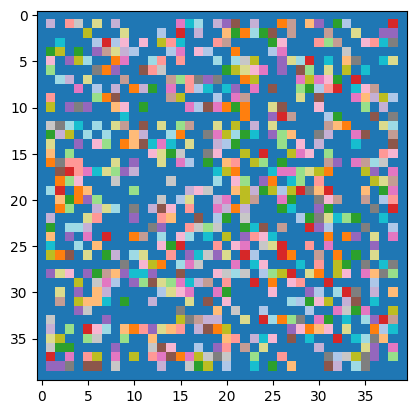

In [6]:
t = KernelLife(40,40, 20, 0.5, p_evo=0.01, mutate_mu=0.05, seed=5)
print(len(t.kernels)-1)
self = t
t.show()

  0%|          | 0/2000 [00:00<?, ?it/s]

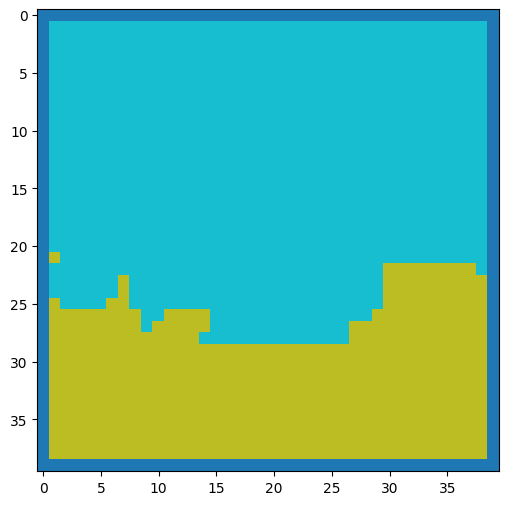

In [28]:
for i in tqdm(range(2000)):
    t.step_evo()
    t.step()
    t.save_hist()
    
t.show()

In [8]:
%matplotlib notebook
from matplotlib import animation

plt.rcParams['figure.figsize'] = [6.,6.]

fig, ax = plt.subplots()
plt.tight_layout()
ims = []
# last_n = 30
a,b = 0,-1

for i in list(range(len(t.maps_history)))[a:b]:
# for i in list(range(len(t.maps_history)))[-last_n:]:
    im = t.maps2im(t.maps_history[i])
    im = ax.imshow(im, cmap='tab20', vmax=t.n_types-1, animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)
plt.show()

<IPython.core.display.Javascript object>

In [9]:
# from IPython import display
# v = ani.to_html5_video()
# display.HTML(v)

# ani.save("x_life_0.mp4", writer="ffmpeg")

In [30]:
# plot the history of count of each type
counts_history = []
for map in t.maps_history:
    counts = np.bincount(map[0], minlength=t.n_types)[:]
    counts[0] = 0
    counts_history.append(counts)
counts_history = np.array(counts_history)
counts_history.shape

(4001, 20)

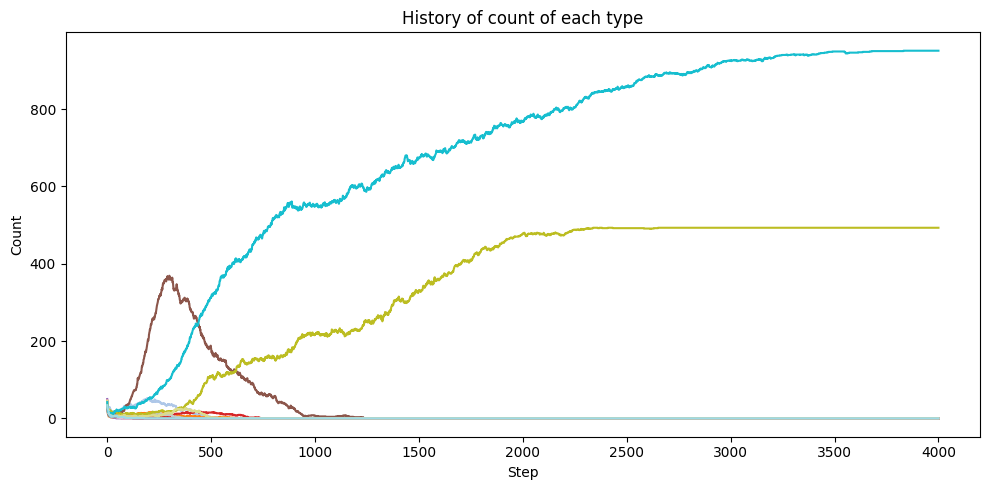

In [37]:
%matplotlib inline
# use colormap tab20, plot the history of count of each type
plt.figure(figsize=(10,5))
for i in range(1, t.n_types):
    plt.plot(counts_history[:,i], color=plt.cm.tab20(i))
plt.title("History of count of each type")
plt.xlabel("Step")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("x_life_0_counts.png")
